In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import fastai
from fastai import *
from fastai.vision import *
from upassai import *
fastai.__version__

'1.0.39'

In [3]:
vggface2_path = '../data/vggface2'

## prepare valid dataset

In [4]:
valid_df = pd.read_csv('dataset/valid_result.csv')
# 20750
valid_df = valid_df.loc[1:6400]

In [5]:
len(valid_df)

6400

In [6]:
valid_source = create_bunch(valid_df, cols='source',
                            path=vggface2_path+'/valid/')
valid_target = create_bunch(valid_df, cols='target',
                            path=vggface2_path+'/valid/')
# valid_source.transform(get_transforms())

In [7]:
valid_ds = TwinDataset(valid_source.train_ds, valid_target.train_ds)

## prepare train dataset

In [8]:
train_df = pd.read_csv('dataset/train_result.csv')
#392050
train_df = train_df.loc[1:384000]
# train_df = train_df.loc[1:160000]

In [9]:
len(train_df)

384000

In [10]:
train_source = create_bunch(train_df, cols='source',
                            path=vggface2_path+'/train/')
train_target = create_bunch(train_df, cols='target',
                            path=vggface2_path+'/train/')

In [11]:
train_ds = TwinDataset(train_source.train_ds, train_target.train_ds)

## final databunch

In [12]:
twin_databunch = DataBunch.create(
    train_ds=train_ds, valid_ds=valid_ds, path=vggface2_path, bs=16)

## training

In [13]:
from fastai.callbacks.tracker import *

In [14]:
import torchvision

In [15]:
learner = Learner(twin_databunch,
                  SiameseNetwork(
                      architecture=torchvision.models.squeezenet1_1,
                      nf=1024, nc=20,
                      lin_ftrs=[800, 500, 300, 100, 50, 20]),
                  loss_func=contrastive_loss,
                  path=twin_databunch.path.joinpath('squeezenet')
                  )

learner.callbacks.append(TerminateOnNaNCallback())
learner.callbacks.append(SaveModelCallback(learner))
learner.callbacks.append(EarlyStoppingCallback(learner, patience=3))

learner

/opt/conda/envs/upass/lib/python3.7/site-packages/torchvision/models/squeezenet.py:94: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  init.kaiming_uniform(m.weight.data)
/opt/conda/envs/upass/lib/python3.7/site-packages/torchvision/models/squeezenet.py:92: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  init.normal(m.weight.data, mean=0.0, std=0.01)


Learner(data=DataBunch;

Train: <upassai.data.TwinDataset object at 0x7f73e9e4be10>;

Valid: <upassai.data.TwinDataset object at 0x7f7402364e48>;

Test: None, model=SiameseNetwork(
  (body): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
      (1): ReLU(inplace)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
      (3): Fire(
        (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
        (squeeze_activation): ReLU(inplace)
        (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
        (expand1x1_activation): ReLU(inplace)
        (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (expand3x3_activation): ReLU(inplace)
      )
      (4): Fire(
        (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
        (squeeze_activation): ReLU(inplace)
        (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
        (expand1

In [16]:
learner.load('squeezenet_model')

Learner(data=DataBunch;

Train: <upassai.data.TwinDataset object at 0x7f73e9e4be10>;

Valid: <upassai.data.TwinDataset object at 0x7f7402364e48>;

Test: None, model=SiameseNetwork(
  (body): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
      (1): ReLU(inplace)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
      (3): Fire(
        (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
        (squeeze_activation): ReLU(inplace)
        (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
        (expand1x1_activation): ReLU(inplace)
        (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (expand3x3_activation): ReLU(inplace)
      )
      (4): Fire(
        (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
        (squeeze_activation): ReLU(inplace)
        (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
        (expand1

In [17]:
learner.fit_one_cycle(10)

epoch,train_loss,valid_loss
1,1.017660,1.999991
2,1.020460,1.999991
3,1.016296,1.999991
4,1.035443,1.999991


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 5: early stopping


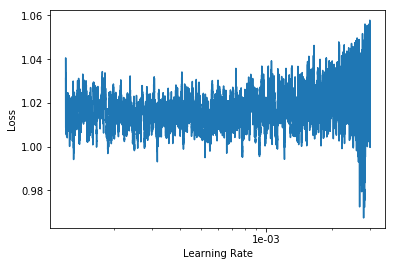

In [18]:
learner.recorder.plot()

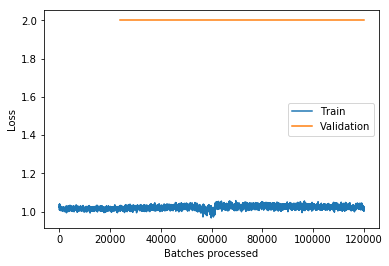

In [19]:
learner.recorder.plot_losses()

In [20]:
learner.save('squeezenet_model')

In [21]:
learner.fit_one_cycle(10)

epoch,train_loss,valid_loss
1,1.013121,1.999991
2,1.013917,1.999991
3,1.031749,1.999991
4,1.031574,1.999991


Epoch 5: early stopping


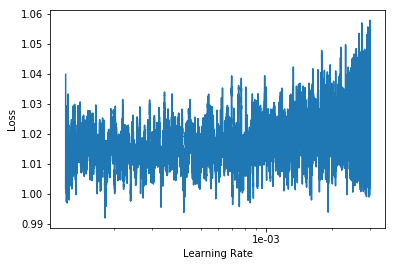

In [22]:
learner.recorder.plot()

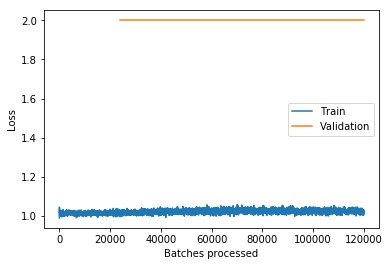

In [23]:
learner.recorder.plot_losses()